# DATA 602 - Advance Programing Techniques
## Final Project - John Ferrara

### Abstract

This project explores how different commuting methods in and around NYC relate to each other. Specifically, how individual vehicle commuting (measured by access-a-ride and NYC bridge and tunnel toll counts) and suburban rail usage (LIRR and Metro North) impact ridership on NYC public transit systems like subways, buses, and the Staten Island Railway. The main goal was to understand whether an increase in vehicle or suburban rail usage correlates with changes in public transit ridership, particularly in a post-COVID context.

Using public data from NYC Open Data, I pulled in and cleaned daily ridership and traffic records from 2020 to 2025, limited the dataset to weekdays, removed the COVID-era years of 2020 and 2021, and created aggregate variables to represent different commuting modes. A linear regression model was built using auto and suburban rail commuters as the predictors, and NYC transit ridership as the outcome.

The model returned an R-squared of about 0.6169, meaning it explains roughly 62 percent of the variation in NYC transit ridership. The coefficients were both statistically significant, with auto commuting associated with an increase of 2.91 riders and suburban rail with an increase of 5.22 riders per unit increase. Some of these results were unexpected and suggest a more complex relationship, possibly due to mixed commute behaviors, such as driving to the subway. While the model works fairly well, residual analysis showed some noise and outliers that could be tied to holidays or atypical events (i.e, weather, remotework, etc.).

Overall, the analysis suggests that both auto-based and suburban rail commuting influence NYC transit ridership, and future work could improve the model by removing outlier days via adding more contextual data liek holidays, weather or policy changes. Additionally, working with more complex transformations of the data could improve the model. 

### Introduction

For this project, I want to explore the impact various commuting methods influence one another. I am focusing on public transit ridership numbers, that means subways, buses, and commuter rail counts. I'm comparing that to how many cars are going over bridges and tunnels using tolls as a measure. The main question I'm attempting to obtain an answer for is: does an change in vehicular traffic or subruban rail ridership correlate with with any drop in public transit ridership? Understanding the nuance between various commuter options is important to help make policy decisions for the city. New initiatives, like congestion pricing, are being implemented in order to help fund the MTA. Analysis on the relationships between transport methods can help inform future decisions. In short, through examining post-COVID toll and MTA ridership data, I am hoping to spot trends that could help inform better transportation decisions for the city and surrounding areas.

In [1]:
#importing all the libs needed
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import scipy.stats as stats
import statsmodels.api as sm

In [2]:
## Reading in NYC MTA ridership data. (https://data.ny.gov/Transportation/MTA-Daily-Ridership-Data-2020-2025/vxuj-8kew/about_data)
## Website says 1776 rows of data.
results= []
#Offset 1000 rows per call, total rows are 1,776
base_url = "https://data.ny.gov/resource/vxuj-8kew.json"
url_suffix = "?$offset=" # Need to do this for getting all data via api; can also use'?$limit='
total_rows = 1776
response = requests.get(base_url)
pull = pd.DataFrame(response.json())
results.append(pull)
for i in range(0, total_rows+1, len(pull)):
    print(i)
    if i == 0:
        continue
    else:
        response = requests.get(base_url+url_suffix+str(i))
        pull = pd.DataFrame(response.json())
        results.append(pull)
mta_rider = pd.concat(results).drop_duplicates()

0
1000


### Exporatory Data Analysis

In [3]:
print("DataFrame Shape: ",mta_rider.shape)
print("__ mta_rider df info: __")
print(mta_rider.info())
### Non null object coutns are equal to the number of rows in all of these columns. No iumputation needs.

DataFrame Shape:  (1776, 15)
__ mta_rider df info: __
<class 'pandas.core.frame.DataFrame'>
Index: 1776 entries, 0 to 775
Data columns (total 15 columns):
 #   Column                                                Non-Null Count  Dtype 
---  ------                                                --------------  ----- 
 0   date                                                  1776 non-null   object
 1   subways_total_estimated_ridership                     1776 non-null   object
 2   subways_of_comparable_pre_pandemic_day                1776 non-null   object
 3   buses_total_estimated_ridersip                        1776 non-null   object
 4   buses_of_comparable_pre_pandemic_day                  1776 non-null   object
 5   lirr_total_estimated_ridership                        1776 non-null   object
 6   lirr_of_comparable_pre_pandemic_day                   1776 non-null   object
 7   metro_north_total_estimated_ridership                 1776 non-null   object
 8   metro_north_of_compa

In [4]:
## Summary Statistics 
## Date Coverage
print("Date Coverage Range")
print(mta_rider['date'].min())
print(mta_rider['date'].max())
## Subway Riders
print("__ Subway Ridership __")
print("Mean: ", round(mta_rider['subways_total_estimated_ridership'].astype(int).mean(),2))
print("Median: ",round(mta_rider['subways_total_estimated_ridership'].astype(int).median(),2))
print("Min: ", mta_rider['subways_total_estimated_ridership'].astype(int).min())
print("Max:", mta_rider['subways_total_estimated_ridership'].astype(int).max())
print("Standard Dev: ",round(mta_rider['subways_total_estimated_ridership'].astype(int).std(),0))
## SI Rail
print("__ Staten Island Rail __")
print("Mean: ", round(mta_rider['staten_island_railway_total_estimated_ridership'].astype(int).mean(),2))
print("Median: ",round(mta_rider['staten_island_railway_total_estimated_ridership'].astype(int).median(),2))
print("Min: ", mta_rider['staten_island_railway_total_estimated_ridership'].astype(int).min())
print("Max:", mta_rider['staten_island_railway_total_estimated_ridership'].astype(int).max())
print("Standard Dev: ",round(mta_rider['staten_island_railway_total_estimated_ridership'].astype(int).std(),2))
## Bus Riders
print("__ Bus Ridership __")
print("Mean: ", round(mta_rider['buses_total_estimated_ridersip'].astype(int).mean(),2))
print("Median: ", round(mta_rider['buses_total_estimated_ridersip'].astype(int).median(),2))
print("Min: ", mta_rider['buses_total_estimated_ridersip'].astype(int).min())
print("Max: ", mta_rider['buses_total_estimated_ridersip'].astype(int).max())
print("Standard Dev: ", round(mta_rider['buses_total_estimated_ridersip'].astype(int).std()))
## Motor Vehicle Est. (bridges_and_tunnels_total_traffic)
print("__ Traffic / Vehicle __")
print("Mean: ", round(mta_rider['bridges_and_tunnels_total_traffic'].astype(int).mean(),2))
print("Median: ", round(mta_rider['bridges_and_tunnels_total_traffic'].astype(int).median(),2))
print("Min: ", mta_rider['bridges_and_tunnels_total_traffic'].astype(int).min())
print("Max: ", mta_rider['bridges_and_tunnels_total_traffic'].astype(int).max())
print("Standard Dev: ",round(mta_rider['bridges_and_tunnels_total_traffic'].astype(int).std(),2))
      
      

Date Coverage Range
2020-03-01T00:00:00.000
2025-01-09T00:00:00.000
__ Subway Ridership __
Mean:  2541830.26
Median:  2505354.0
Min:  198399
Max: 5498809
Standard Dev:  1067641.0
__ Staten Island Rail __
Mean:  4491.96
Median:  4568.5
Min:  0
Max: 17453
Standard Dev:  2700.11
__ Bus Ridership __
Mean:  1011409.18
Median:  1143659.0
Min:  5498
Max:  2244515
Standard Dev:  436980
__ Traffic / Vehicle __
Mean:  857259.62
Median:  897212.0
Min:  156759
Max:  1043802
Standard Dev:  141210.05


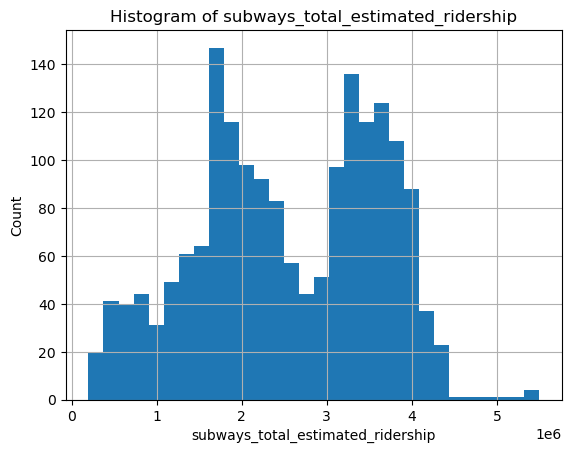

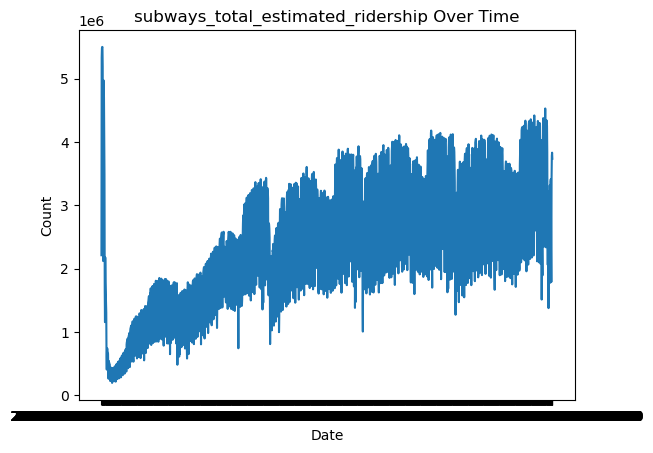

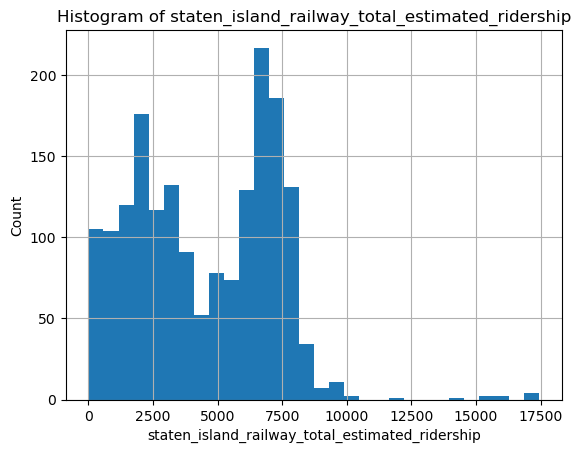

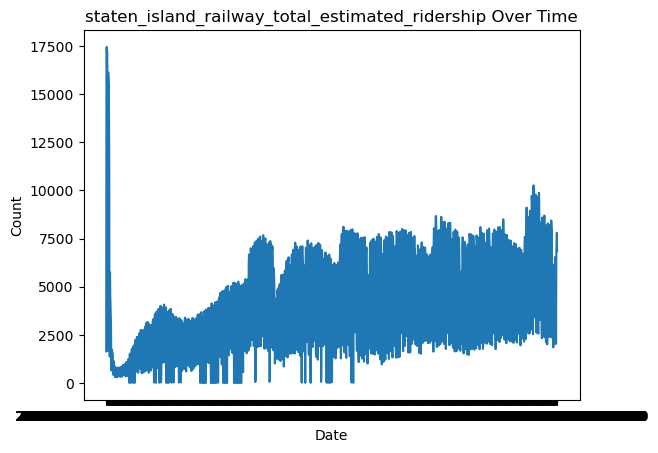

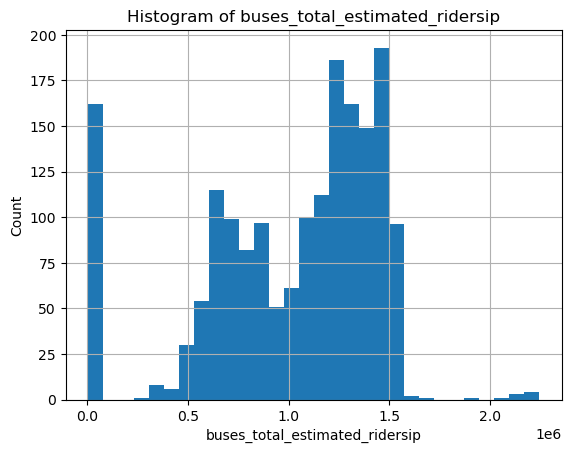

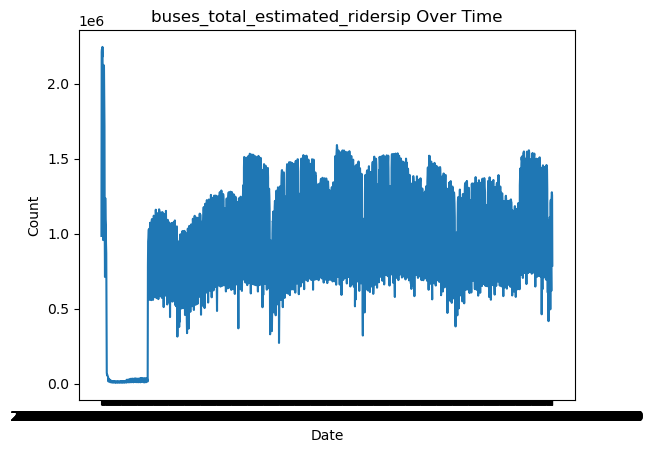

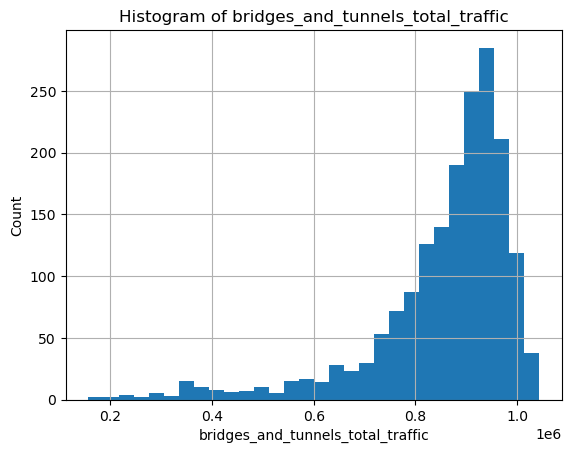

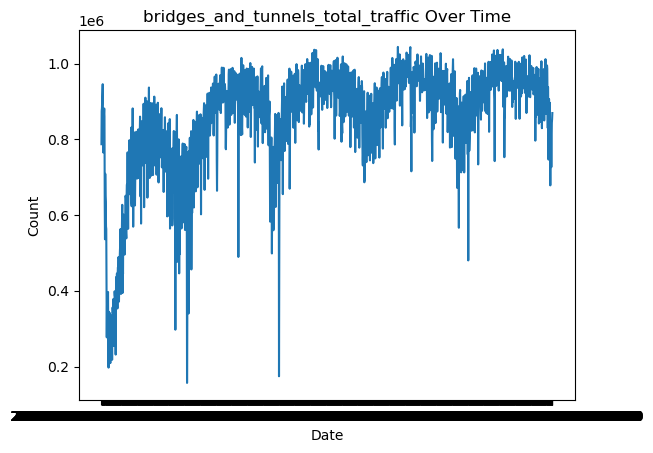

In [5]:
## Basic Prelim Charts for Proposal to show frequncy of amounts
columns_to_plot = [
    'subways_total_estimated_ridership',
    'staten_island_railway_total_estimated_ridership',
    'buses_total_estimated_ridersip',
    'bridges_and_tunnels_total_traffic'
]

for col in columns_to_plot:
    ## Histogram
    mta_rider[col].astype(int).hist(bins=30)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()
    ## Line chart 
    plt.plot(mta_rider['date'], mta_rider[col].astype(int))
    plt.title(f'{col} Over Time')
    plt.xlabel("Date")
    plt.ylabel('Count')
    plt.show()

After looking at the data, there arent any imputation needs because there arent any null values in the data. However, the data needs processing in order to fit the critera needed for the analysis. The data needs to be processed in several ways, including but not limited to:

    - Limiting the data to just weekdays, as we only want to look at commuter behavior. This is made on the assumption that the vast majority of people commute only Monday through Friday. There are obvious exceptions to this, but for this analysis this is the assumption being made.
    
    - The data may need to be aggregated to the weekly level, or otherwise. This would be done by summing up the totals for different transit methods.
    
    - Data type formatting may be needed for the date information. Similar to how each variable column was made into integers above, the date column needs to be converted to a datetime format, with sections of the date (i.e., week number, year, etc.) being parsed out. 
    
    - Additional indices for the commuting methods may be wanted. Proposed aggregate metrics include: 
    
        -Personal Vehicles Travel Commuting 
        
            - bridges_and_tunnels_total_traffic
            
            - access_a_ride_total_scheduled_trips
            
        - Total MTA commuting ridership 
        
            - subways_total_estimated_ridership
            
            - staten_island_railway_total_estimated_ridership
            
            - buses_total_estimated_ridership

        - Suburban Rail Ridership
        
            - lirr_total_estimated_ridership 

            - metro_north_total_estimated_ridership 
            
    - The relationship bewteen the MTA means of transit within may also be examined. For instance: Train vs Bus ridership. 

    - Lastly we want to remove Covid years from the data, this means 2020 and 2021 will be removed from the data. Most COVID policies were in place, and impacting most people during these years


### Data Wrangling

In [6]:
### Droping COlumns we dont want for analysis and formatting the ones we want to keep as ints
for c in mta_rider.columns:
    print(c)
    if c == 'date':
        continue
    if "pre_pandemic_day" in c:
        mta_rider.drop(columns=[c], inplace=True)
        print(f"{c} column dropped")
    else:
        mta_rider[c]=mta_rider[c].astype(int)
        print(f"{c} converted to int.")

date
subways_total_estimated_ridership
subways_total_estimated_ridership converted to int.
subways_of_comparable_pre_pandemic_day
subways_of_comparable_pre_pandemic_day column dropped
buses_total_estimated_ridersip
buses_total_estimated_ridersip converted to int.
buses_of_comparable_pre_pandemic_day
buses_of_comparable_pre_pandemic_day column dropped
lirr_total_estimated_ridership
lirr_total_estimated_ridership converted to int.
lirr_of_comparable_pre_pandemic_day
lirr_of_comparable_pre_pandemic_day column dropped
metro_north_total_estimated_ridership
metro_north_total_estimated_ridership converted to int.
metro_north_of_comparable_pre_pandemic_day
metro_north_of_comparable_pre_pandemic_day column dropped
access_a_ride_total_scheduled_trips
access_a_ride_total_scheduled_trips converted to int.
access_a_ride_of_comparable_pre_pandemic_day
access_a_ride_of_comparable_pre_pandemic_day column dropped
bridges_and_tunnels_total_traffic
bridges_and_tunnels_total_traffic converted to int.
brid

In [7]:
### Converting the Date column to time stamp, currentl the dates are strings
print("Checking format of the date")
print(type(mta_rider['date'].iloc[0]))
mta_rider['date'] = pd.to_datetime(mta_rider['date'])

### Keeping only Monday through Friday
mta_rider['day_of_week']=mta_rider['date'].dt.day_name()
print("Checking its all days of week in raw data.")
print(mta_rider['day_of_week'].unique())
mta_weekdays = mta_rider[~mta_rider['day_of_week'].isin(["Sunday","Saturday"])]
## Confirming results
print("New Limited DF should be just weekdays:")
print(mta_weekdays['day_of_week'].unique())

### Converting the time stamps to a week number, and parsing out year to combine. 
mta_weekdays['week_number'] = mta_weekdays['date'].dt.isocalendar().week
mta_weekdays['year'] = mta_weekdays['date'].dt.isocalendar().year
mta_weekdays["YYYYWW"] = mta_weekdays['year'].astype(str) + '-W' +  mta_weekdays['week_number'].astype(str).str.zfill(2)

### Aggregating by week for weekly commuting numbers
mta_weekday_agg = mta_weekdays.groupby(["year","week_number","YYYYWW"]).agg({
    'subways_total_estimated_ridership':sum,
     'buses_total_estimated_ridersip':sum,
     'lirr_total_estimated_ridership':sum,
     'metro_north_total_estimated_ridership':sum,
     'access_a_ride_total_scheduled_trips':sum,
     'bridges_and_tunnels_total_traffic':sum,
     'staten_island_railway_total_estimated_ridership':sum}).reset_index()

## Removing COvid years
mta_weekdays = mta_weekdays[~mta_weekdays['year'].astype(str).isin(['2021','2020'])]
mta_weekday_agg = mta_weekday_agg[~mta_weekday_agg['year'].astype(str).isin(['2021','2020'])]

Checking format of the date
<class 'str'>
Checking its all days of week in raw data.
['Sunday' 'Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday' 'Saturday']
New Limited DF should be just weekdays:
['Monday' 'Tuesday' 'Wednesday' 'Thursday' 'Friday']


C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\2066596915.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_weekdays['week_number'] = mta_weekdays['date'].dt.isocalendar().week
C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\2066596915.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_weekdays['year'] = mta_weekdays['date'].dt.isocalendar().year
C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\2066596915.py:18: SettingWithCopyWarning: 
A value is tryin

We now have two different dataframes to use for this analysis:

    - mta_weekday_agg:weekly aggregate data fore weekdays

    - mta_weekdays:  daily information on a daily level for weekdays

Taking a look at the data via a pairs plot. 

#### Weekly Aggregate Analysis 

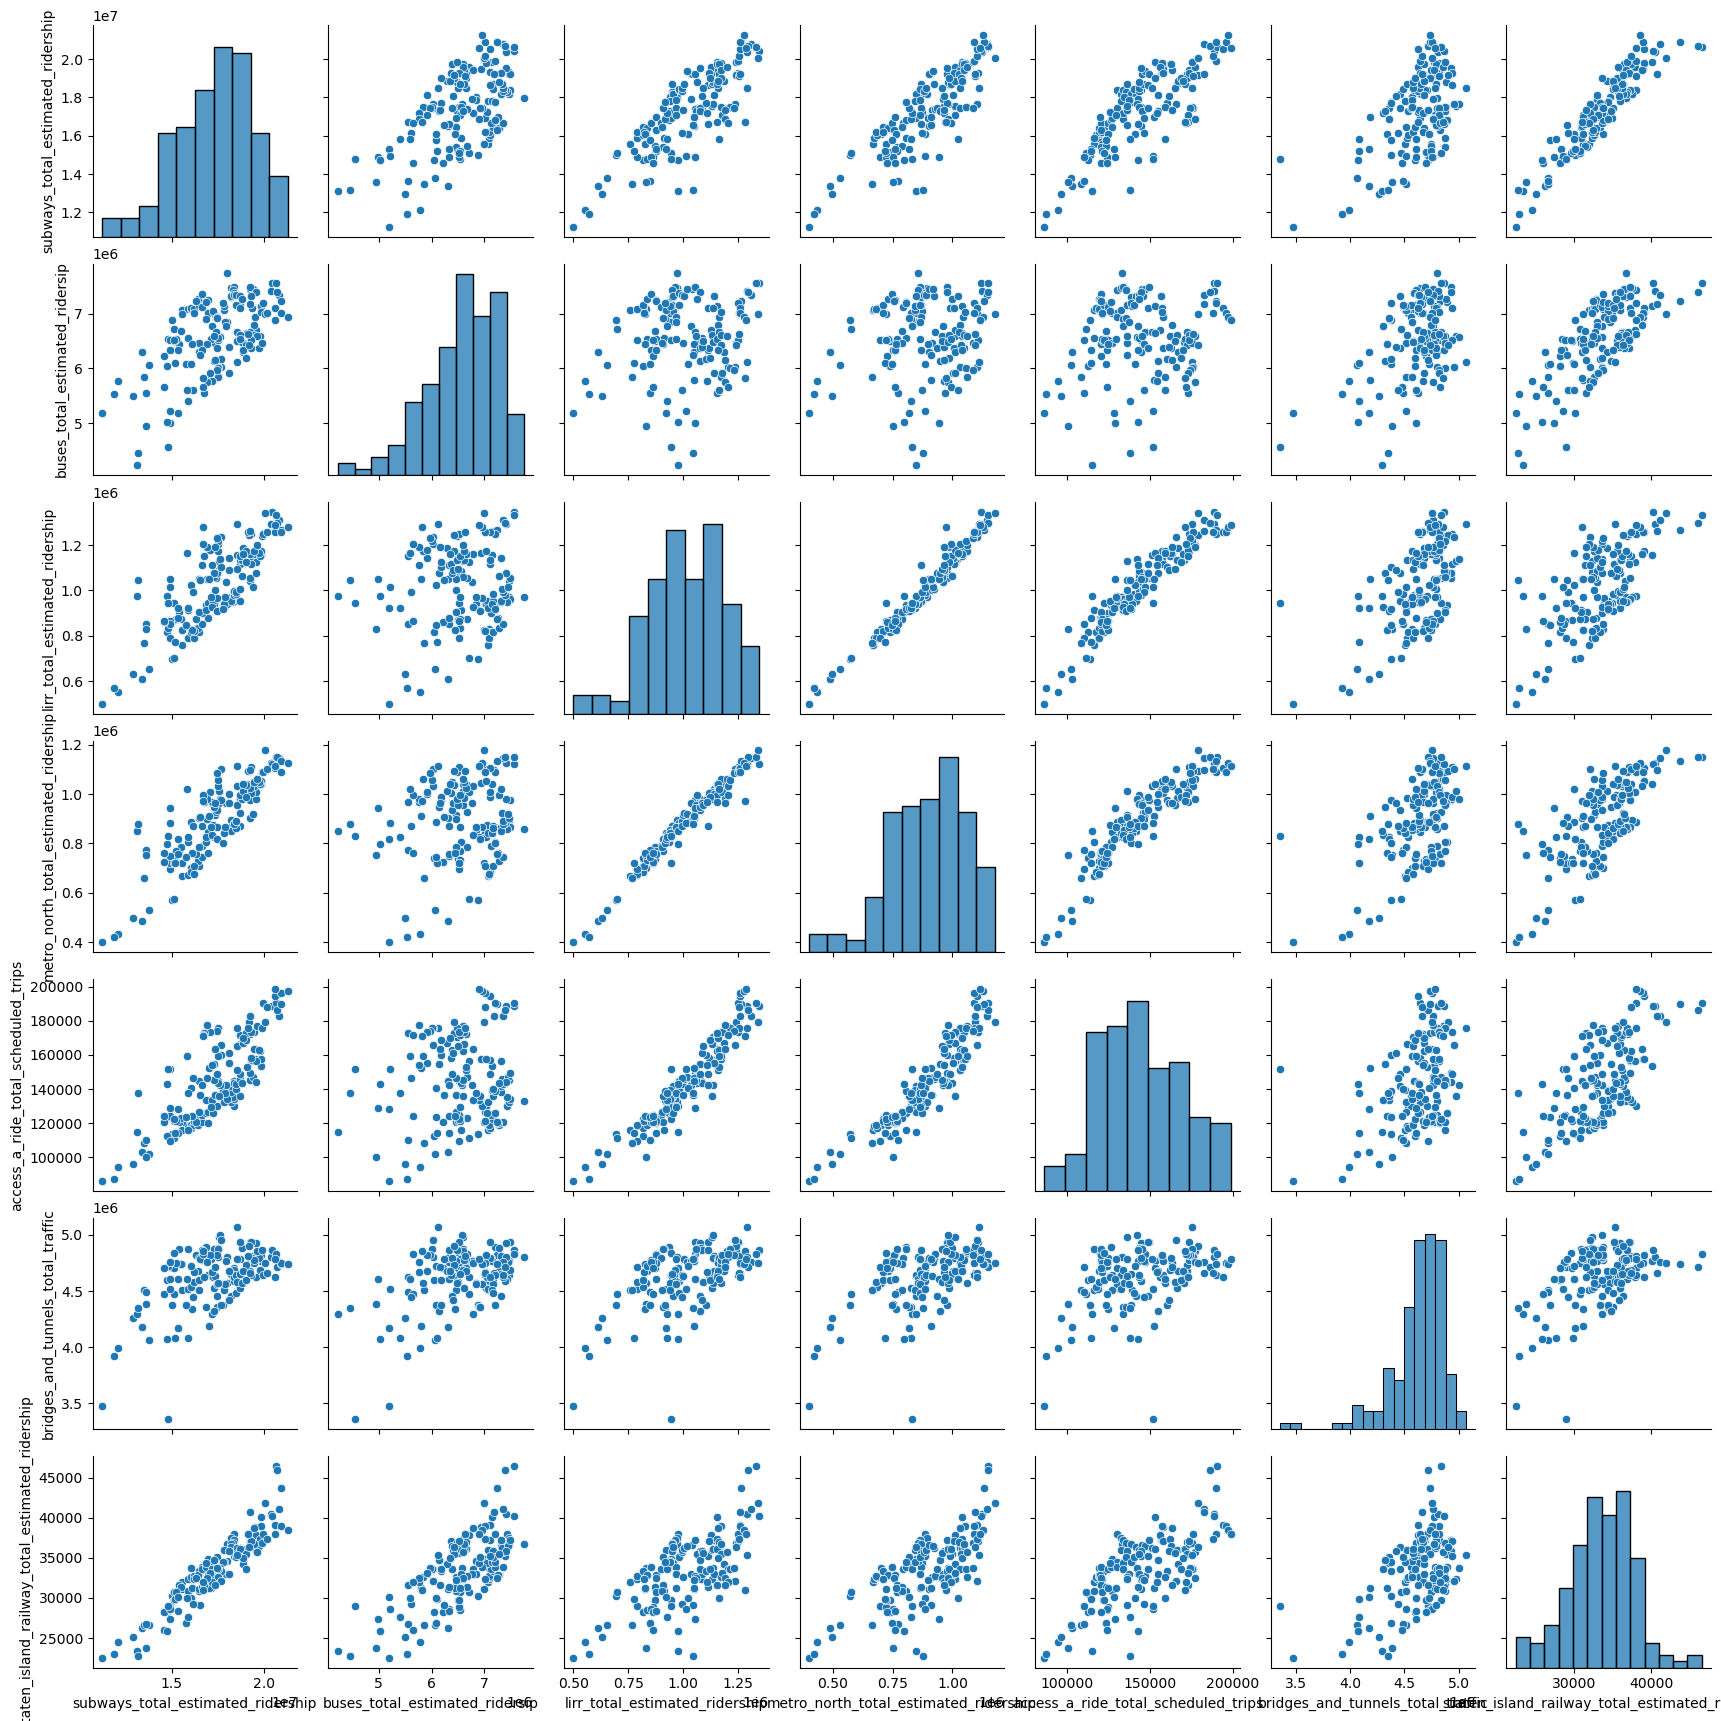

In [8]:
## Taking a look at the data now that it is processed and wrangled. 
## Removing the Date oriented columns for plotting 
pair_plot_df = mta_weekday_agg[['subways_total_estimated_ridership','buses_total_estimated_ridersip', 'lirr_total_estimated_ridership',
                              'metro_north_total_estimated_ridership','access_a_ride_total_scheduled_trips','bridges_and_tunnels_total_traffic',
                              'staten_island_railway_total_estimated_ridership']]
sns.pairplot(pair_plot_df)
plt.show()

#### Daily Weekday Analysis

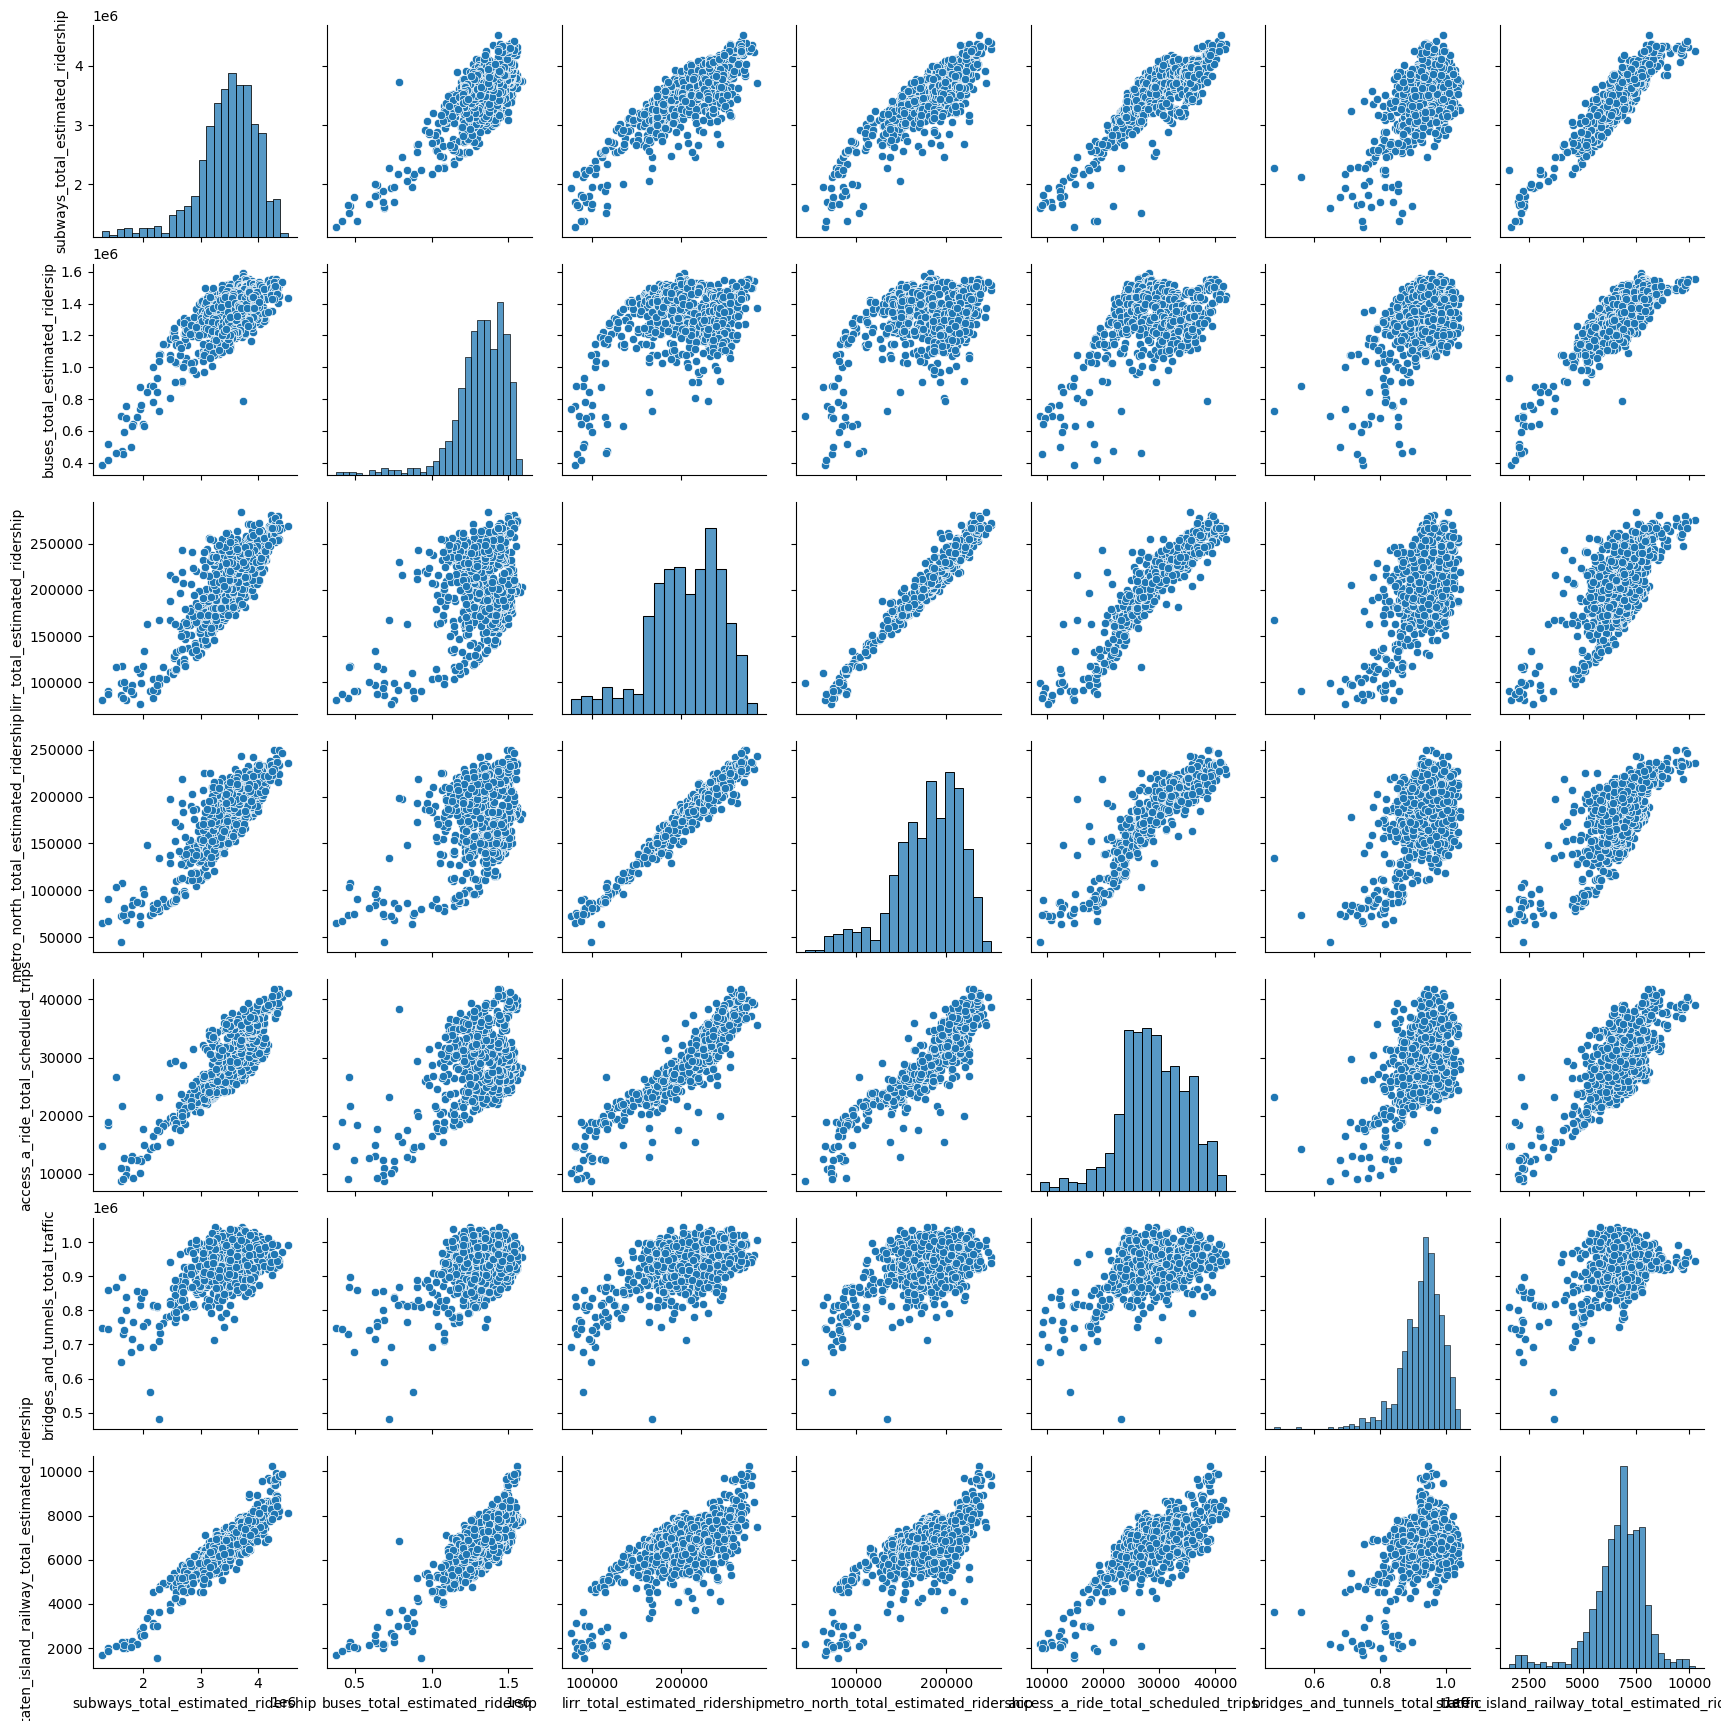

In [9]:
## Taking a look at the data now that it is processed and wrangled. 
## Removing the Date oriented columns for plotting 
pair_plot_df = mta_weekdays[['subways_total_estimated_ridership','buses_total_estimated_ridersip', 'lirr_total_estimated_ridership',
                              'metro_north_total_estimated_ridership','access_a_ride_total_scheduled_trips','bridges_and_tunnels_total_traffic',
                              'staten_island_railway_total_estimated_ridership']]
sns.pairplot(pair_plot_df)
plt.show()

There seems to be more variation in the relationships seen in the pair plots on the daily level, we will continue forward with the daily-level data as it seems to have valuable nuance. However, there also seems to be a decent amount of multicolinearity that could prove problematic for our regression analysis. In order to help control for this, we will create the aggregate variables from the individual columns, so as to reduce this as a potential issue the aggregate variables will be as follows: 

    - NYC transit commuters
    
        - subways_total_estimated_ridership
        
        - staten_island_railway_total_estimated_ridership
            
        - buses_total_estimated_ridership
    
    - Personal Vehicles Travel Commuting  
    
        - bridges_and_tunnels_total_traffic
            
        - access_a_ride_total_scheduled_trips
            
    - Total Suburban Rail commuting ridership 
        
        - metro_north_total_estimated_ridership

        - lirr_total_estimated_ridership
    

In [10]:
## Creating Agg variables
mta_weekdays['nyc_transit_commuters'] = mta_weekdays["subways_total_estimated_ridership"] + mta_weekdays["staten_island_railway_total_estimated_ridership"] + mta_weekdays["buses_total_estimated_ridersip"]
mta_weekdays['auto_commuters'] = mta_weekdays["access_a_ride_total_scheduled_trips"]+mta_weekdays["bridges_and_tunnels_total_traffic"]
mta_weekdays['suburb_rail_commuters'] = mta_weekdays["lirr_total_estimated_ridership"]+mta_weekdays["metro_north_total_estimated_ridership"]

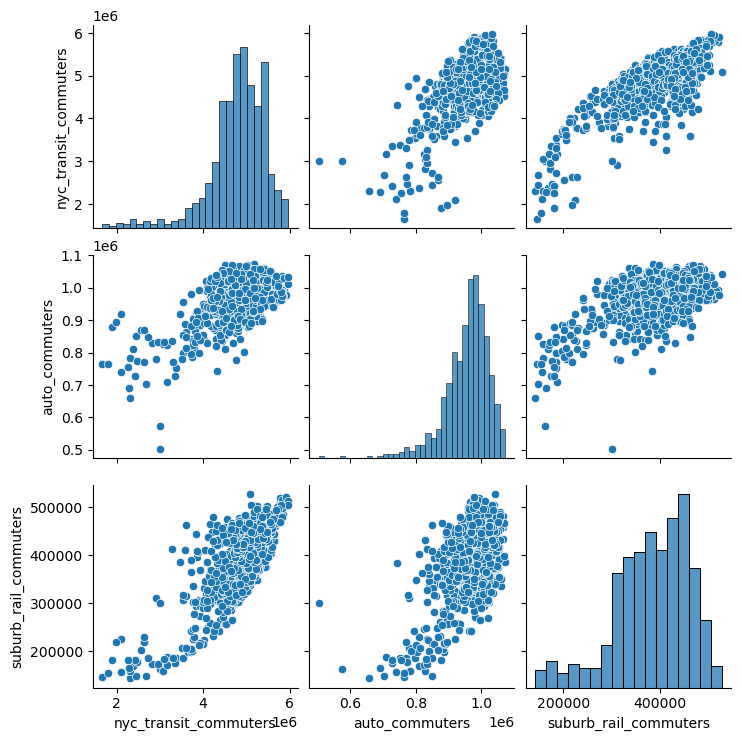

In [11]:
### Limiting to the columns i need to the regression, also performing an additional pairs plot with new variables. 
mta_weekdays_limited = mta_weekdays[["date",'week_number', 'year', 'YYYYWW', 'nyc_transit_commuters',
                                      'auto_commuters', 'suburb_rail_commuters']]
pair_plot_df = mta_weekdays_limited[[c for c in mta_weekdays_limited.columns if c not in ["date",'week_number', 'year', 'YYYYWW']]]
sns.pairplot(pair_plot_df)
plt.show()

C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\36421455.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_weekdays_limited['nyc_transit_commuters_logged'] = np.log(mta_weekdays_limited['nyc_transit_commuters'])
C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\36421455.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta_weekdays_limited['auto_commuters_logged'] = np.log(mta_weekdays_limited['auto_commuters'])
C:\Users\jferrara_personal\AppData\Local\Temp\ipykernel_21988\

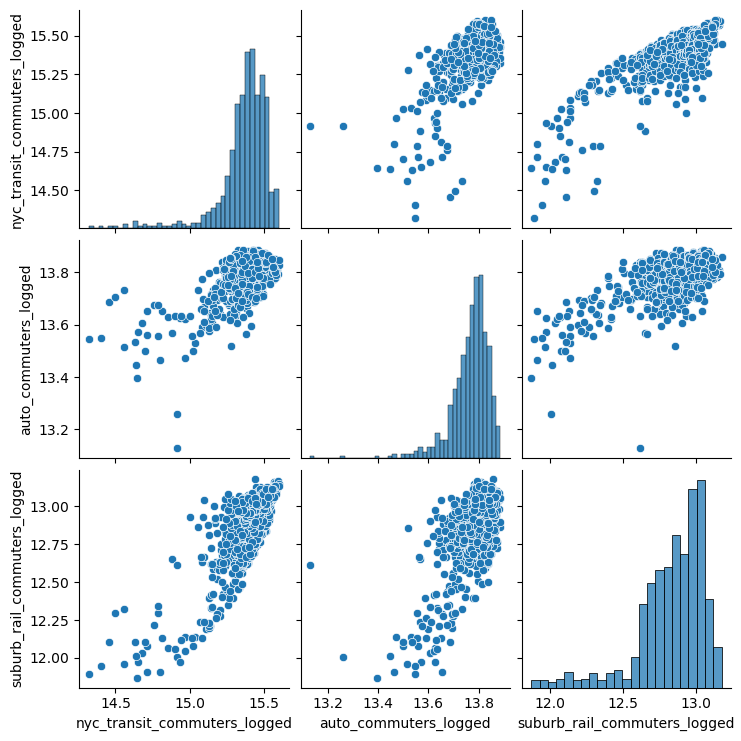

In [12]:
## Testin siumple log transformations on some of these variables
mta_weekdays_limited['nyc_transit_commuters_logged'] = np.log(mta_weekdays_limited['nyc_transit_commuters'])
mta_weekdays_limited['auto_commuters_logged'] = np.log(mta_weekdays_limited['auto_commuters'])
mta_weekdays_limited['suburb_rail_commuters_logged'] = np.log(mta_weekdays_limited['suburb_rail_commuters'])


mta_weekdays_limited_log = mta_weekdays_limited[["date",'week_number', 'year', 'YYYYWW', 'nyc_transit_commuters_logged',
                                      'auto_commuters_logged', 'suburb_rail_commuters_logged']]
pair_plot_df = mta_weekdays_limited_log[[c for c in mta_weekdays_limited_log.columns if c not in ["date",'week_number', 'year', 'YYYYWW']]]
sns.pairplot(pair_plot_df)
plt.show()

Overall the data is fairly normal in its distributiions. Most of the data is left skewed, with a longer left sided tail having smaller values. An attempt at a simnple log transformation in the datas didnt seem to change the state of things. This is according to a basic visual review of the data. As a result, I am continuing with the raw data and not the log trasnformed data. 

### Data Analysis

In [13]:
## Begining the regression analysis

## Stating the anticipated dependent variable. Which is the nyc_transit_commuters, as thie variable will be impacted by the
## theoretical increase /decrease in suburban rail and vehicle traffic. 
x = mta_weekdays_limited[['auto_commuters', 'suburb_rail_commuters']] #independent / predictor vars
y = mta_weekdays_limited['nyc_transit_commuters'] #dependent

# Spliting the data from 70% / 30% train / test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

# Making MODel
model = LinearRegression()
model.fit(x_train, y_train)

# Checking accuracy
y_pred = model.predict(x_test)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
residuals_test = y_test - y_pred

y_pred_train = model.predict(x_train)
residuals_train = y_train - y_pred_train

print("Coefficients for 'auto_commuters', 'suburb_rail_commuters':", model.coef_)
print("Intercept:", model.intercept_)
print("R-squared:", r2)
print("Root Mean Squared Error (RMSE):", rmse)


Coefficients for 'auto_commuters', 'suburb_rail_commuters': [2.30572373 5.50123802]
Intercept: 466301.6159451008
R-squared: 0.616926834807202
Root Mean Squared Error (RMSE): 376585.9687222033


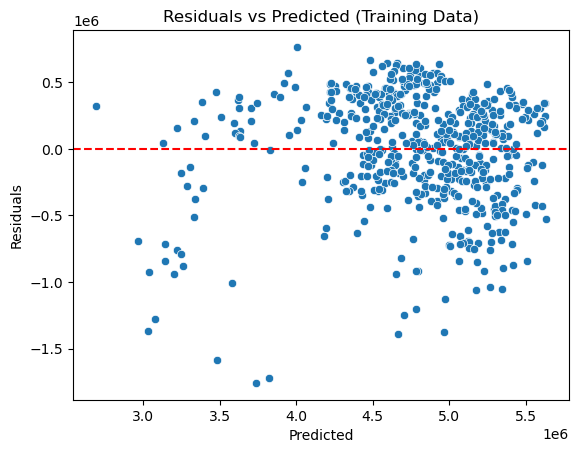

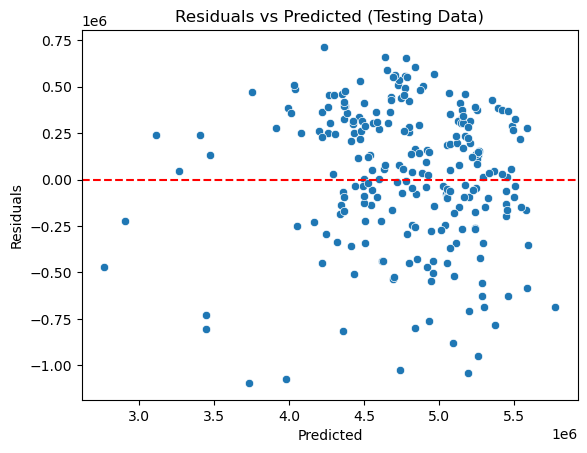

In [14]:
## Plotting the Residuals to ensure model is valid. 

### TRAINING DATA RESIDUALS
sns.scatterplot(x=y_pred_train, y=residuals_train)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Training Data)")
plt.show()

### TEST DATA RESIDUALS
sns.scatterplot(x=y_pred, y=residuals_test)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Testing Data)")
plt.show()

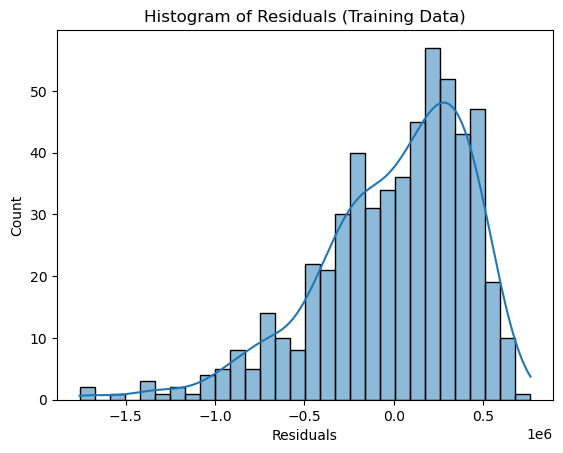

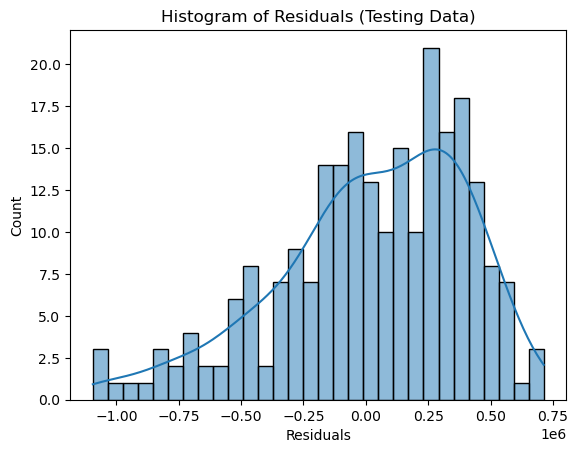

In [15]:
sns.histplot(residuals_train, kde=True, bins=30)
plt.title("Histogram of Residuals (Training Data)")
plt.xlabel("Residuals")
plt.show()


sns.histplot(residuals_test, kde=True, bins=30)
plt.title("Histogram of Residuals (Testing Data)")
plt.xlabel("Residuals")
plt.show()

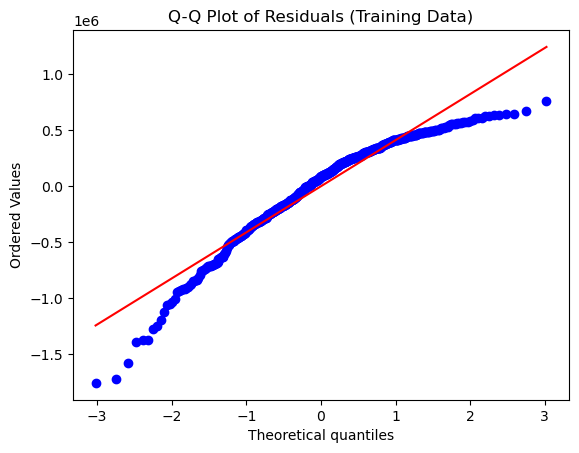

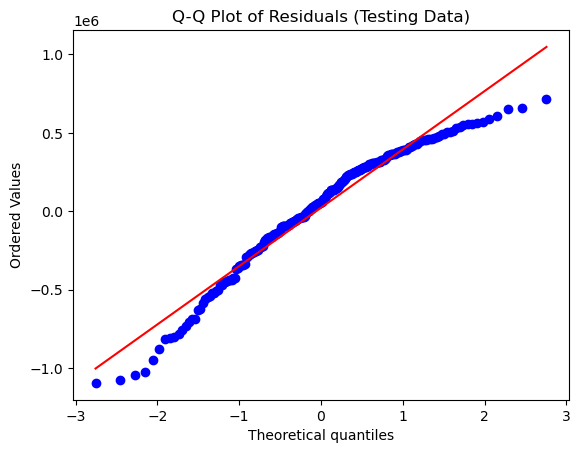

In [16]:
stats.probplot(residuals_train, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Training Data)")
plt.show()


stats.probplot(residuals_test, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals (Testing Data)")
plt.show()


The model is a decent fit, but not perfect. There is some ambiguity around the linearity of the residuals, as seen in both the residual vs. predicted plots, histograms, and the Q-Q plots. In the QQ plot, while the center trend is captured fairly well, there are some visible curves and deviations at the tails that suggest the linear assumptions may not fully hold. The residual vs. predicted scatter plot shows outlier residuals that disturb the desired neutral random clusting around zero that one would wish to see in a good model. These outliers tend to be in the lower and left portion of the charts. Lastly, the histogram shows a nearly normal distrubution with a left tail. 

Methods like a Box-Cox transformation may help address these issues. These could improve linearity and stabilize the variance of the residuals across different levels of predicted values. Additionally, the outliers that are visible in the residual plots may need to be dealt with. These could represent specific weekdays that were impacted by unusual events, such as holidays, weather disruptions, popular remote working days, or other external factors that caused ridership or vehicle counts to deviate from typical patterns. These points could be removed, flagged, or analyzed separately depending on how much they influence the overall model for future analysis.

#### Secondary Model Method for Final Chekcs

In [17]:
## Used Sklearn for first attempt at model and prelim stats, but wanted a n r-like summary of the model used statsmodels to print it.
## On the same training data
print("---------------------------On the Same Training Data-----------------")
x_train_const = sm.add_constant(x_train)
model_train = sm.OLS(y_train, x_train_const).fit()
print(model_train.summary())


## On entire set in order to see how results vary for just viewing the relationship and not predicting. 
print("---------------------------On all the data ---------------------------")
x_const = sm.add_constant(x)
model_full = sm.OLS(y, x_const).fit()
print(model_full.summary())

## Mainly wanted to check p values as well. 

---------------------------On the Same Training Data-----------------
                              OLS Regression Results                             
Dep. Variable:     nyc_transit_commuters   R-squared:                       0.621
Model:                               OLS   Adj. R-squared:                  0.619
Method:                    Least Squares   F-statistic:                     449.4
Date:                   Thu, 17 Apr 2025   Prob (F-statistic):          2.54e-116
Time:                           16:02:51   Log-Likelihood:                -7935.2
No. Observations:                    552   AIC:                         1.588e+04
Df Residuals:                        549   BIC:                         1.589e+04
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------

Lastly, for the analysis and modeling section, I generated the same model using a different python library in order to obtain a summary more similar to that in r. This was used to confirm that the p-values were good, and to take a look at the model AIC and BIC values were ok. 

### Conclusion

In conclusion, the model built in this project does a decent job at showing how commuting methods in and around NYC relate to each other. I used "auto_commuters" and "suburban_rail_commuters" as the predictors, with "nyc_transit_commuters" as the target variable that I was trying to explain. The model returned an R-squared of about 0.6169, meaning it explains roughly 62 percent of the variation in nyc transit ridership. The root mean squared error (RMSE) was around 376,586, which seems large, but that is expected given the size of the values in the data.

The coefficients from the regression show that both predictor variables have a clear relationship with NYC transit usage. For every one-unit increase in auto commuters, which would be access-a-rides and NYC bridge and tunnel toll counts, the model estimates nyc transit ridership goes up by about 2.91 people. While initially, i expected this to be more of a negative relationship, essentially the more drivers the less NYC transit riders. However, the relationship is more murky, individuals may drive to the train or partake in other types of mixed commutes. More inline with my intial hypothesis was the relationship between suburban rail commuters and NYC transit ridership. For every one-unit increase in suburban rail commuters, so those taking the LIRR and Metro North, the NYC transit ridership metric goes up by about 5.22 people. Both of these coefficients are statistically significant, with both p-values essentially being zero. 

While the model does provide some insight, there is definitely room for improvement. There is noise in the residuals whick implies its uncertain that the relationship is totally linear. The residual plots and Q-Q plots showed some curve and a few strong outliers that could be from weekday holidays where offices are closed, the influence of weather events, remote work daya, or other random events that threw off typical commuter patterns. If one was to improve upon and build out this analysis, removing holidays from the data for each year and joining in weather events into the data to flag such days, would be beneficial.

Beyond adding additional contextual data, transforming the existing data would most likely prove beneficial as well. Attemping transformations beyong simple logs, using methods like Box-Cox, or other non-linear regression modeling techniques could provide for stronger insights into the influence these commuter variables have on one another. 

Overall, the relationship between commuting methods seems pretty clear. This analysis shows that both auto and suburban rail usage have an impact on NYC transit ridership.